# Introduction

The aim of this notebook is to stress the Raspberry Pi 4 for deciding between different cases and cooling types.

Sources:

- [https://github.com/nschloe/stressberry](https://github.com/nschloe/stressberry)
- [https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/](https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/)

# Implementation of helper functions

## Load globally used libraries and set plot parameters

In [1]:
import subprocess
#from time import sleep
from os import cpu_count
import threading
import time

import smbus2
import bme280

import pandas as pd
import numpy as np
import prettytable as pt

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

# FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. 
# The converter was registered by pandas on import. 
# Future versions of pandas will require you to explicitly register matplotlib converters.
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#import matplotlib.pyplot as plt
#%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'png')

plt.rcParams['savefig.dpi'] = 80
plt.rcParams['savefig.bbox'] = "tight"

plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = 10, 6
plt.rcParams['axes.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 14

# Need to install dependent package first via 'apt install cm-super'
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
#plt.rcParams['text.latex.preamble'] = r'\usepackage{subdepth}, \usepackage{type1cm}'
#plt.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}' , r'\usepackage[T1]{fontenc}', r'\usepackage{subdepth}', r'\usepackage{type1cm}']
#plt.rcParams['text.latex.unicode'] = True

/home/bk/jupyter-env/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`


## Variant 1: Function for reading the CPU core temperature

This implementation retrieves the temperature information from the system file `/sys/class/thermal/thermal_zone0/temp`.

In [2]:
import os

# Function for reading the CPU core temperature
# Found here: https://www.pragmaticlinux.com/2020/06/check-the-raspberry-pi-cpu-temperature/
def get_cpu_temp_old():
    """
    Obtains the current value of the CPU temperature.
    :returns: Current value of the CPU temperature if successful, zero value otherwise.
    :rtype: float
    """
    # Initialize the result.
    result = 0.0
    # The first line in this file holds the CPU temperature as an integer times 1000.
    # Read the first line and remove the newline character at the end of the string.
    if os.path.isfile('/sys/class/thermal/thermal_zone0/temp'):
        with open('/sys/class/thermal/thermal_zone0/temp') as f:
            line = f.readline().strip()
        # Test if the string is an integer as expected.
        if line.isdigit():
            # Convert the string with the CPU temperature to a float in degrees Celsius.
            result = float(line) / 1000
    # Give the result back to the caller.
    return result

## Variant 2: Function for reading the CPU core temperature (used here)

This implementation retrieves the temperature information from the command line tool `vcgencmd`. In the bash console you can get the same result by issuing:
```bash
$ vcgencmd measure_temp
```

In [3]:
#import subprocess

# Function for reading the CPU core temperature
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def get_cpu_temp(filename=None):
    """Returns the core temperature in Celsius."""
    if filename is not None:
        with open(filename) as f:
            temp = float(f.read()) / 1000
    else:
        # Using vcgencmd is specific to the raspberry pi
        out = subprocess.check_output(["vcgencmd", "measure_temp"]).decode("utf-8")
        temp = float(out.replace("temp=", "").replace("'C", ""))
    
    return temp

## Function for reading the CPU core frequency

The frequency information is retrieved from the command line tool `vcgencmd` also. In the bash console you can get the same result by issuing:
```bash
$ vcgencmd measure_clock arm
```

In [4]:
#import subprocess

# Function for reading the CPU core frequency
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def get_cpu_freq(filename=None):
    """Returns the CPU frequency in MHz"""
    if filename is not None:
        with open(filename) as f:
            frequency = float(f.read()) / 1000
    else:
        # Only vcgencmd measure_clock arm is accurate on Raspberry Pi.
        # Per: https://www.raspberrypi.org/forums/viewtopic.php?f=63&t=219358&start=25
        out = subprocess.check_output(["vcgencmd", "measure_clock arm"]).decode("utf-8")
        frequency = float(out.split("=")[1]) / 1000000
    
    return frequency

## Function for reading the ambient temperature

In order to compare the recorded CPU core temperatures of the different housing and cooling scenarios, the temperature curves must be normalized with the curves of the simultaneously measured ambient temperature.  
However, only the curves of the so-called "overtemperature" are comparable, which is the difference between the curves of the CPU core temperature and the ambient temperature.

The external Bosch sensor *BME280* is used to measure the ambient temperature. This is connected to the Raspberry Pi via a USB-I2C adapter. The installation of the required kernel module is described in the Jupyter notebook [BME280.ipynb](./BME280.ipynb).

In [6]:
# i2c bus on /dev/i2c-11
port = 11
# i2c address of BME280
address = 0x76
bus = smbus2.SMBus(port)

# Function for reading the ambient temperature
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def get_ambient_temp():
    """Returns the ambient temperature in Celsius."""
    
    calibration_params = bme280.load_calibration_params(bus, address)

    # the sample method will take a single reading and return
    # a compensated_reading object
    data_obj = bme280.sample(bus, address, calibration_params)
    
    return data_obj.temperature

## Helper functions for stressing all cores of the CPU

Stress is created by the command line tool `stress`. It has to be installed first by issuing:
```bash
$ sudo apt install stress
```

In [7]:
# Helper function to call the 'stress' command line tool
def stress_cpu(num_cpus, time):
    subprocess.check_call(["stress", "--cpu", str(num_cpus), "--timeout", f"{time}s"])
    return

In [8]:
#from time import sleep
#from os import cpu_count

# Function for stressing all cores of the CPU
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/main.py
def run_stress(stress_duration=300, idle_duration=120, cores=None):
    """Run stress test for specified duration with specified idle times
    at the start and end of the test.
    """
    if cores is None:
        cores = cpu_count()

    print(f"Preparing to stress [{cores}] CPU Cores for [{stress_duration}] seconds")
    print(f"Idling for {idle_duration} seconds...")
    time.sleep(idle_duration)

    print(f"Starting the stress load on [{cores}] CPU Cores for [{stress_duration}] seconds")
    stress_cpu(num_cpus=cores, time=stress_duration)

    print(f"Idling for {idle_duration} seconds...")
    time.sleep(idle_duration)

## Helper function to let the CPU cool down

This function is used to let the CPU cool down first to find a stable baseline.

In [9]:
#from time import sleep

def cpu_cooldown(interval=60, filename=None):
    """Lets the CPU cool down until the temperature does not change anymore."""
    prev_tmp = get_cpu_temp()
    while True:
        time.sleep(interval)
        tmp = get_cpu_temp()
        print(
            f"Current temperature: {tmp:4.1f}°C - "
            f"Previous temperature: {prev_tmp:4.1f}°C"
        )
        if abs(tmp - prev_tmp) < 0.2:
            break
        prev_tmp = tmp
    return tmp

## Helper function for handling dataframes

First, a dataframe is created and at the same time the column headers are set. The function ```dataframe_add_row()``` is used to add the measured values to the dataframe in the form of new rows.

In [10]:
#import pandas as pd

# Dataframe for the measuring values
df_meas_values = pd.DataFrame(columns=['Time', 'CPU Temperature', 'CPU Frequency', 'Ambient Temperature'])

In [11]:
def dataframe_add_row(df=None, row=[]):
    if (df is None):
        return
    
    # Add a row
    df.loc[-1] = row
    
    # Shift the index
    df.index = df.index + 1
    
    # Reset the index of dataframe and avoid the old index being added as a column
    df.reset_index(drop=True, inplace=True)

## Main worker function

In [12]:
#import threading
#import time

# Function for running the stress test in another thread while measuring CPU temperature and frequency
# Found here: https://github.com/nschloe/stressberry/blob/main/stressberry/cli/run.py
def run(argv=None):
    # Cool down first
    print("Awaiting stable baseline temperature ...")
    cpu_cooldown(interval=60)

    # Start the stress test in another thread
    t = threading.Thread(
        target=lambda: run_stress(stress_duration=900, idle_duration=300, cores=4), args=()
    )
    # Init event handler for killing the thread
    t.event = threading.Event()
    # Start the thread
    t.start()

    # Init row array
    values_row = []
    # Get starting time
    start_time = time.time()
    while t.is_alive():
        try:
            # Get time relative to starting time and round to 1 decimal
            timestamp = float("{:.1f}".format(time.time() - start_time))
            # Get CPU temperature and round to 1 decimal
            temperature_cpu = float("{:.1f}".format(get_cpu_temp()))
            # Get ambient temperature and round to 1 decimal
            temperature_ambient = float("{:.1f}".format(get_ambient_temp()))
            # Get CPU frequency and round to 1 decimal
            frequency = float("{:.1f}".format(get_cpu_freq()))

            values_row = [ timestamp,
                           temperature_cpu,
                           frequency,
                           temperature_ambient
                         ]

            dataframe_add_row(df_meas_values, values_row)

            print(
                    f"Time: {timestamp} s,\t"
                    f"CPU Temperature: {temperature_cpu} °C,\t"
                    f"Ambient Temperature: {temperature_ambient} °C,\t"
                    f"Frequency: {frequency} MHz"
                 )

            # Choose the sample interval such that we have a respectable number of data points
            t.join(2.0)
            
        except:
            print("Keyboard Interrupt ^C detected.")
            print("Bye.")
            # Stop the thread by calling the event
            t.event.set()
            break
        
    # Normalize times so we are starting at '0 s'
    #time0 = df_meas_values['Time'][0]
    # It's a really fancy oneliner - but not necessary at all ...
    #df_meas_values['Time'] = [tm - time0 for tm in df_meas_values['Time']]

# Run the heating test

In [13]:
# Clear all data in dataframe
df_meas_values = df_meas_values.iloc[0:0]

run()

Awaiting stable baseline temperature ...
Current temperature: 45.7°C - Previous temperature: 47.2°C
Current temperature: 46.7°C - Previous temperature: 45.7°C
Current temperature: 46.2°C - Previous temperature: 46.7°C
Current temperature: 46.7°C - Previous temperature: 46.2°C
Current temperature: 47.7°C - Previous temperature: 46.7°C
Current temperature: 47.7°C - Previous temperature: 47.7°C
Preparing to stress [4] CPU Cores for [900] seconds
Idling for 300 seconds...
Time: 0.0 s,	CPU Temperature: 47.2 °C,	Ambient Temperature: 20.4 °C,	Frequency: 1500.4 MHz
Time: 2.1 s,	CPU Temperature: 47.2 °C,	Ambient Temperature: 20.4 °C,	Frequency: 900.2 MHz
Time: 4.2 s,	CPU Temperature: 46.2 °C,	Ambient Temperature: 20.4 °C,	Frequency: 700.2 MHz
Time: 6.4 s,	CPU Temperature: 46.7 °C,	Ambient Temperature: 20.4 °C,	Frequency: 1000.3 MHz
Time: 8.5 s,	CPU Temperature: 47.2 °C,	Ambient Temperature: 20.4 °C,	Frequency: 800.2 MHz
Time: 10.6 s,	CPU Temperature: 47.7 °C,	Ambient Temperature: 20.4 °C,	Frequ

In [16]:
display(df_meas_values)

,Time,CPU Temperature,CPU Frequency,Ambient Temperature
0,0.0,47.2,1500.4,20.4
1,2.1,47.2,900.2,20.4
2,4.2,46.2,700.2,20.4
3,6.4,46.7,1000.3,20.4
4,8.5,47.2,800.2,20.4
...,...,...,...,...
695,1491.3,48.7,700.2,20.3
696,1493.4,48.2,700.2,20.3
697,1495.6,48.7,900.2,20.3
698,1497.7,49.1,700.2,20.3


# Save all to CSV files

In [17]:
# Write dataframe to CSV file
str_file_prefix_b4 = 'RaspiB4JupyterLab_stress_measurement'
str_file_prefix_b3plus = 'RaspiB3plusEPaper_stress_measurement'

#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_woHeatSinks.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinks.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan5V.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan3V.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan5Vrev.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_pinkRaspiCase_wHeatSinks.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan5V.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan3V.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan5Vrev.csv', sep ='\t', index = False, header=True)
#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_woCase_wHeatSinksAndCtrlFan5V_70C.csv', sep ='\t', index = False, header=True)
df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b4 + '_woCase_wHeatSinksAndCtrlFan5V_65C.csv', sep ='\t', index = False, header=True)

#df_meas_values.to_csv(r'./data_files/' + str_file_prefix_b3plus + '_PlasticCase_wHeatSinks.csv', sep ='\t', index = False, header=True)

# Read in the CSV files and display it

## Read in the CSV files in dataframes

In [34]:
#import pandas as pd

# Helper function for creating dataframes from CSV files
def create_dictionary_from_csv(filename, offset=0, cols_wanted=1):
    my_dataframe = pd.read_csv(filename, sep='\t', index_col=False, decimal='.', header=offset)
    
    # Delete all cloumns after the desired ones
    my_dataframe.drop(my_dataframe.columns[cols_wanted:], axis=1, inplace=True)

    return my_dataframe

In [36]:
str_file_prefix_b4 = 'RaspiB4JupyterLab_stress_measurement'
str_file_prefix_b3plus = 'RaspiB3plusEPaper_stress_measurement'

str_file_name_1 = str_file_prefix_b4 + '_PlasticCase_woHeatSinks.csv'
str_file_name_2 = str_file_prefix_b4 + '_PlasticCase_wHeatSinks.csv'
str_file_name_3 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan5V.csv'
str_file_name_4 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan3V.csv'
str_file_name_5 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndFan5Vrev.csv'
str_file_name_6 = str_file_prefix_b4 + '_pinkRaspiCase_wHeatSinks.csv'
str_file_name_7 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan5V.csv'
str_file_name_8 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan3V.csv'
str_file_name_11 = str_file_prefix_b4 + '_PlasticCase_wHeatSinksAndNoctuaFan5Vrev.csv'

str_file_name_10 = str_file_prefix_b4 + '_woCase_wHeatSinksAndCtrlFan5V_70C.csv'
str_file_name_12 = str_file_prefix_b4 + '_woCase_wHeatSinksAndCtrlFan5V_65C.csv'

str_file_name_9 = str_file_prefix_b3plus + '_PlasticCase_wHeatSinks.csv'

df_1_PC_woHeatSinks = create_dictionary_from_csv(filename="./data_files/" + str_file_name_1, offset=0, cols_wanted=4)
df_2_PC_wHeatSinks = create_dictionary_from_csv(filename="./data_files/" + str_file_name_2, offset=0, cols_wanted=4)
df_3_PC_wHeatSinksAndFan5V = create_dictionary_from_csv(filename="./data_files/" + str_file_name_3, offset=0, cols_wanted=4)
df_4_PC_wHeatSinksAndFan3V = create_dictionary_from_csv(filename="./data_files/" + str_file_name_4, offset=0, cols_wanted=4)
df_5_PC_wHeatSinksAndFan5Vrev = create_dictionary_from_csv(filename="./data_files/" + str_file_name_5, offset=0, cols_wanted=4)
df_6_RC_wHeatSinks = create_dictionary_from_csv(filename="./data_files/" + str_file_name_6, offset=0, cols_wanted=4)
df_7_PC_wHeatSinksAndNoctuaFan5V = create_dictionary_from_csv(filename="./data_files/" + str_file_name_7, offset=0, cols_wanted=4)
df_8_PC_wHeatSinksAndNoctuaFan3V = create_dictionary_from_csv(filename="./data_files/" + str_file_name_8, offset=0, cols_wanted=4)
df_11_PC_wHeatSinksAndNoctuaFan5Vrev = create_dictionary_from_csv(filename="./data_files/" + str_file_name_11, offset=0, cols_wanted=4)

df_10_woC_wHeatSinksAndCtrlFan5V_70C = create_dictionary_from_csv(filename="./data_files/" + str_file_name_10, offset=0, cols_wanted=4)
df_12_woC_wHeatSinksAndCtrlFan5V_65C = create_dictionary_from_csv(filename="./data_files/" + str_file_name_12, offset=0, cols_wanted=4)

df_9_PC_wHeatSinks = create_dictionary_from_csv(filename="./data_files/" + str_file_name_9, offset=0, cols_wanted=4)

In [37]:
#df_1_PC_woHeatSinks.head(6)
#df_2_PC_wHeatSinks.head(6)
#df_3_PC_wHeatSinksAndFan5V.head(6)
#df_4_PC_wHeatSinksAndFan3V.head(6)
#df_5_PC_wHeatSinksAndFan5Vrev.head(6)
#df_6_RC_wHeatSinks.head(6)
#df_7_PC_wHeatSinksAndNoctuaFan5V.head(6)
#df_8_PC_wHeatSinksAndNoctuaFan3V.head(6)
#df_11_PC_wHeatSinksAndNoctuaFan5Vrev.head(6)

#df_10_woC_wHeatSinksAndCtrlFan5V_70C.head(6)
df_12_woC_wHeatSinksAndCtrlFan5V_65C.head(6)

#df_9_PC_wHeatSinks.head(6)

,Time,CPU Temperature,CPU Frequency,Ambient Temperature
0,0.0,47.2,1500.4,20.4
1,2.1,47.2,900.2,20.4
2,4.2,46.2,700.2,20.4
3,6.4,46.7,1000.3,20.4
4,8.5,47.2,800.2,20.4
5,10.6,47.7,900.2,20.4


In [38]:
#df_1_PC_woHeatSinks.dtypes
#df_2_PC_wHeatSinks.dtypes
#df_3_PC_wHeatSinksAndFan5V.dtypes
#df_4_PC_wHeatSinksAndFan3V.dtypes
#df_5_PC_wHeatSinksAndFan5Vrev.dtypes
#df_6_RC_wHeatSinks.dtypes
#df_7_PC_wHeatSinksAndNoctuaFan5V.dtypes
#df_8_PC_wHeatSinksAndNoctuaFan3V.dtypes
#df_11_PC_wHeatSinksAndNoctuaFan5Vrev.dtypes

#df_10_woC_wHeatSinksAndCtrlFan5V_70C.dtypes
df_12_woC_wHeatSinksAndCtrlFan5V_65C.dtypes

#df_9_PC_wHeatSinks.dtypes

Time                   float64
CPU Temperature        float64
CPU Frequency          float64
Ambient Temperature    float64
dtype: object

## Smoothing with a moving average filter

In [39]:
# Smooth temperature column only!
df_1_PC_woHeatSinks['CPU Temperature'] = df_1_PC_woHeatSinks['CPU Temperature'].rolling(window=3).mean()
df_2_PC_wHeatSinks['CPU Temperature'] = df_2_PC_wHeatSinks['CPU Temperature'].rolling(window=3).mean()
df_3_PC_wHeatSinksAndFan5V['CPU Temperature'] = df_3_PC_wHeatSinksAndFan5V['CPU Temperature'].rolling(window=3).mean()
df_4_PC_wHeatSinksAndFan3V['CPU Temperature'] = df_4_PC_wHeatSinksAndFan3V['CPU Temperature'].rolling(window=3).mean()
df_5_PC_wHeatSinksAndFan5Vrev['CPU Temperature'] = df_5_PC_wHeatSinksAndFan5Vrev['CPU Temperature'].rolling(window=3).mean()
df_6_RC_wHeatSinks['CPU Temperature'] = df_6_RC_wHeatSinks['CPU Temperature'].rolling(window=3).mean()
df_7_PC_wHeatSinksAndNoctuaFan5V['CPU Temperature'] = df_7_PC_wHeatSinksAndNoctuaFan5V['CPU Temperature'].rolling(window=3).mean()
df_8_PC_wHeatSinksAndNoctuaFan3V['CPU Temperature'] = df_8_PC_wHeatSinksAndNoctuaFan3V['CPU Temperature'].rolling(window=3).mean()
df_11_PC_wHeatSinksAndNoctuaFan5Vrev['CPU Temperature'] = df_11_PC_wHeatSinksAndNoctuaFan5Vrev['CPU Temperature'].rolling(window=3).mean()

df_10_woC_wHeatSinksAndCtrlFan5V_70C['CPU Temperature'] = df_10_woC_wHeatSinksAndCtrlFan5V_70C['CPU Temperature'].rolling(window=3).mean()
df_12_woC_wHeatSinksAndCtrlFan5V_65C['CPU Temperature'] = df_12_woC_wHeatSinksAndCtrlFan5V_65C['CPU Temperature'].rolling(window=3).mean()

df_9_PC_wHeatSinks['CPU Temperature'] = df_9_PC_wHeatSinks['CPU Temperature'].rolling(window=3).mean()

In [40]:
df_12_woC_wHeatSinksAndCtrlFan5V_65C

,Time,CPU Temperature,CPU Frequency,Ambient Temperature
0,0.0,NaN,1500.4,20.4
1,2.1,NaN,900.2,20.4
2,4.2,46.866667,700.2,20.4
3,6.4,46.700000,1000.3,20.4
4,8.5,46.700000,800.2,20.4
...,...,...,...,...
695,1491.3,48.666667,700.2,20.3
696,1493.4,48.666667,700.2,20.3
697,1495.6,48.533333,900.2,20.3
698,1497.7,48.666667,700.2,20.3


## Display / Plot data from dataframes

### Comparative representation of the temperature curves

This is a comparative representation of the temperature curves over all examined cooling variants for Raspberry Pi B4 and 3B+.

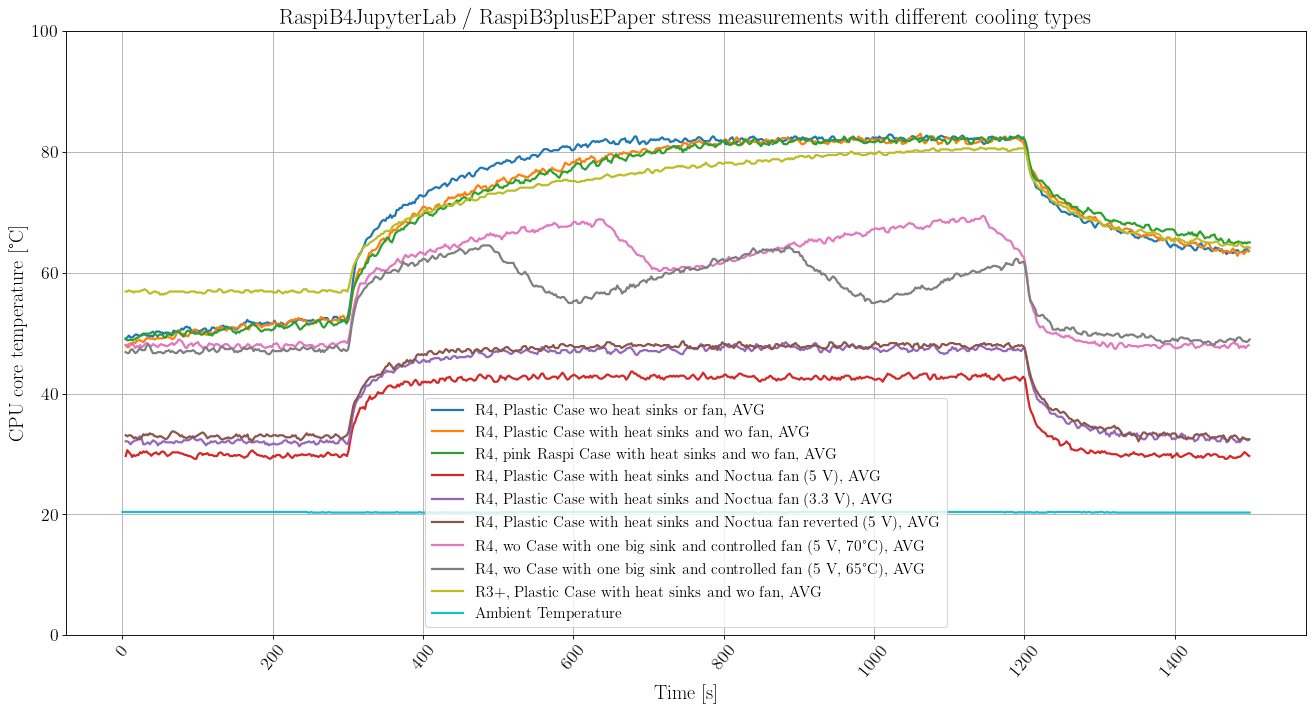

In [41]:
# figsize: a tuple (width, height) in inches
plt.figure(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')
axes = plt.gca()

#xfmt = mdates.DateFormatter('%H:%M:%S')
#axes.xaxis.set_major_formatter(xfmt)

plt.title('RaspiB4JupyterLab / RaspiB3plusEPaper stress measurements with different cooling types')

#plt.plot(df_1_PC_woHeatSinks['Time'], df_1_PC_woHeatSinks['CPU Temperature'], '-', label='Plastic Case wo heat sinks or fan')
#plt.plot(df_2_PC_wHeatSinks['Time'], df_2_PC_wHeatSinks['CPU Temperature'], '-', label='Plastic Case with heat sinks and wo fan')
#plt.plot(df_3_PC_wHeatSinksAndFan5V['Time'], df_3_PC_wHeatSinksAndFan5V['CPU Temperature'], '-', label='Plastic Case with heat sinks and fan (5 V)')
#plt.plot(df_4_PC_wHeatSinksAndFan3V['Time'], df_4_PC_wHeatSinksAndFan3V['CPU Temperature'], '-', label='Plastic Case with heat sinks and fan (3.3 V)')
#plt.plot(df_5_PC_wHeatSinksAndFan5Vrev['Time'], df_5_PC_wHeatSinksAndFan5Vrev['CPU Temperature'], '-', label='Plastic Case with heat sinks and fan reverted (5 V)')
#plt.plot(df_6_RC_wHeatSinks['Time'], df_6_RC_wHeatSinks['CPU Temperature'], '-', label='pink Raspi Case with heat sinks and and wo fan')

plt.plot(df_1_PC_woHeatSinks['Time'], df_1_PC_woHeatSinks['CPU Temperature'], '-', label='R4, Plastic Case wo heat sinks or fan, AVG')
plt.plot(df_2_PC_wHeatSinks['Time'], df_2_PC_wHeatSinks['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and wo fan, AVG')
#plt.plot(df_3_PC_wHeatSinksAndFan5V['Time'], df_3_PC_wHeatSinksAndFan5V['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and cheap fan (5 V), AVG')
#plt.plot(df_4_PC_wHeatSinksAndFan3V['Time'], df_4_PC_wHeatSinksAndFan3V['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and cheap fan (3.3 V), AVG')
#plt.plot(df_5_PC_wHeatSinksAndFan5Vrev['Time'], df_5_PC_wHeatSinksAndFan5Vrev['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and cheap fan reverted (5 V), AVG')
plt.plot(df_6_RC_wHeatSinks['Time'], df_6_RC_wHeatSinks['CPU Temperature'], '-', label='R4, pink Raspi Case with heat sinks and wo fan, AVG')
plt.plot(df_7_PC_wHeatSinksAndNoctuaFan5V['Time'], df_7_PC_wHeatSinksAndNoctuaFan5V['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and Noctua fan (5 V), AVG')
plt.plot(df_8_PC_wHeatSinksAndNoctuaFan3V['Time'], df_8_PC_wHeatSinksAndNoctuaFan3V['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and Noctua fan (3.3 V), AVG')
plt.plot(df_11_PC_wHeatSinksAndNoctuaFan5Vrev['Time'], df_11_PC_wHeatSinksAndNoctuaFan5Vrev['CPU Temperature'], '-', label='R4, Plastic Case with heat sinks and Noctua fan reverted (5 V), AVG')

plt.plot(df_10_woC_wHeatSinksAndCtrlFan5V_70C['Time'], df_10_woC_wHeatSinksAndCtrlFan5V_70C['CPU Temperature'], '-', label='R4, wo Case with one big sink and controlled fan (5 V, 70°C), AVG')
plt.plot(df_12_woC_wHeatSinksAndCtrlFan5V_65C['Time'], df_12_woC_wHeatSinksAndCtrlFan5V_65C['CPU Temperature'], '-', label='R4, wo Case with one big sink and controlled fan (5 V, 65°C), AVG')

plt.plot(df_9_PC_wHeatSinks['Time'], df_9_PC_wHeatSinks['CPU Temperature'], '-', label='R3+, Plastic Case with heat sinks and wo fan, AVG')

plt.plot(df_12_woC_wHeatSinksAndCtrlFan5V_65C['Time'], df_12_woC_wHeatSinksAndCtrlFan5V_65C['Ambient Temperature'], '-', label='Ambient Temperature')

plt.xlabel('Time [s]')
plt.ylabel('CPU core temperature [°C]')

plt.ylim(0, 100)

plt.grid(True)

plt.setp(plt.gca().xaxis.get_majorticklabels(), 'rotation', 50)

plt.legend()

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_RaspiB3plusEPaper_stress_measurement'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### RaspiB3plusEPaper: Temperature curve compared with the curve of the CPU frequency (passive cooling)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi 3B+ with the cooling variant "glued-on heat sinks without fan".

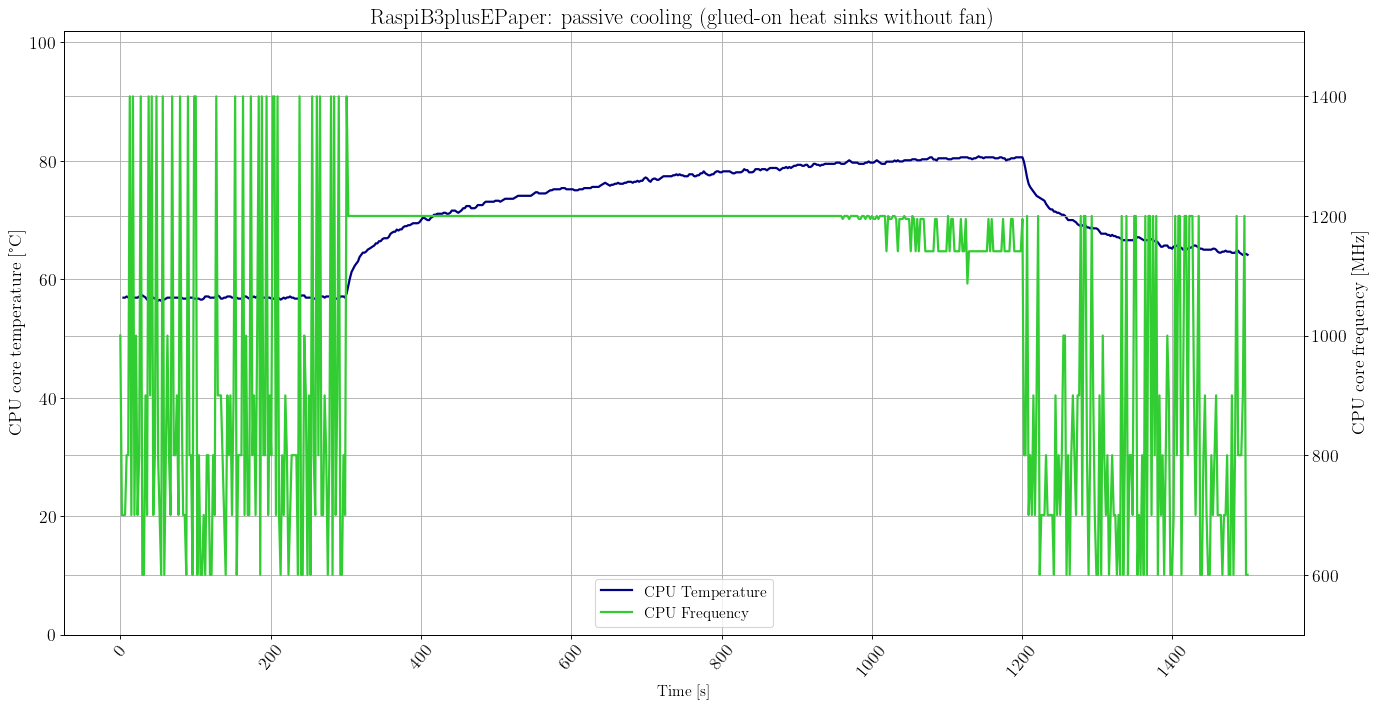

In [24]:
# Figsize: a tuple (width, height) in inches
# Create figure and axis objects with subplots()
fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

axes = plt.gca()

plt.title('RaspiB3plusEPaper: passive cooling (glued-on heat sinks without fan)')

line1 = ax1.plot(df_9_PC_wHeatSinks['Time'], df_9_PC_wHeatSinks['CPU Temperature'], color='navy', label='CPU Temperature')

# Set x-axis label
ax1.set_xlabel('Time [s]', fontsize=14)
# Set y-axis label
ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
ax1.set_ylim(0, 102)
ax1.grid(True)
plt.xticks(rotation=50)

# Twin object for two different y-axis on the same plot
ax2 = ax1.twinx()

line2 = ax2.plot(df_9_PC_wHeatSinks['Time'], df_9_PC_wHeatSinks['CPU Frequency'], color='limegreen', label='CPU Frequency')

# Set y-axis label
ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
ax2.set_ylim(500, 1510)
ax2.grid(True)

# Add all lines to the same legend box
lines_all = line1+line2
labels = [l.get_label() for l in lines_all]
ax1.legend(lines_all, labels, loc='lower center')

# Save plot to PNG and PDF
str_image_name = 'RaspiB3plusEPaper_stress_measurement_PC_wHeatSinks'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### RaspiB4JupyterLab: Temperature curve compared with the curve of the CPU frequency (passive cooling: without heat sinks or fan)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "passive cooling: without heat sinks or fan".

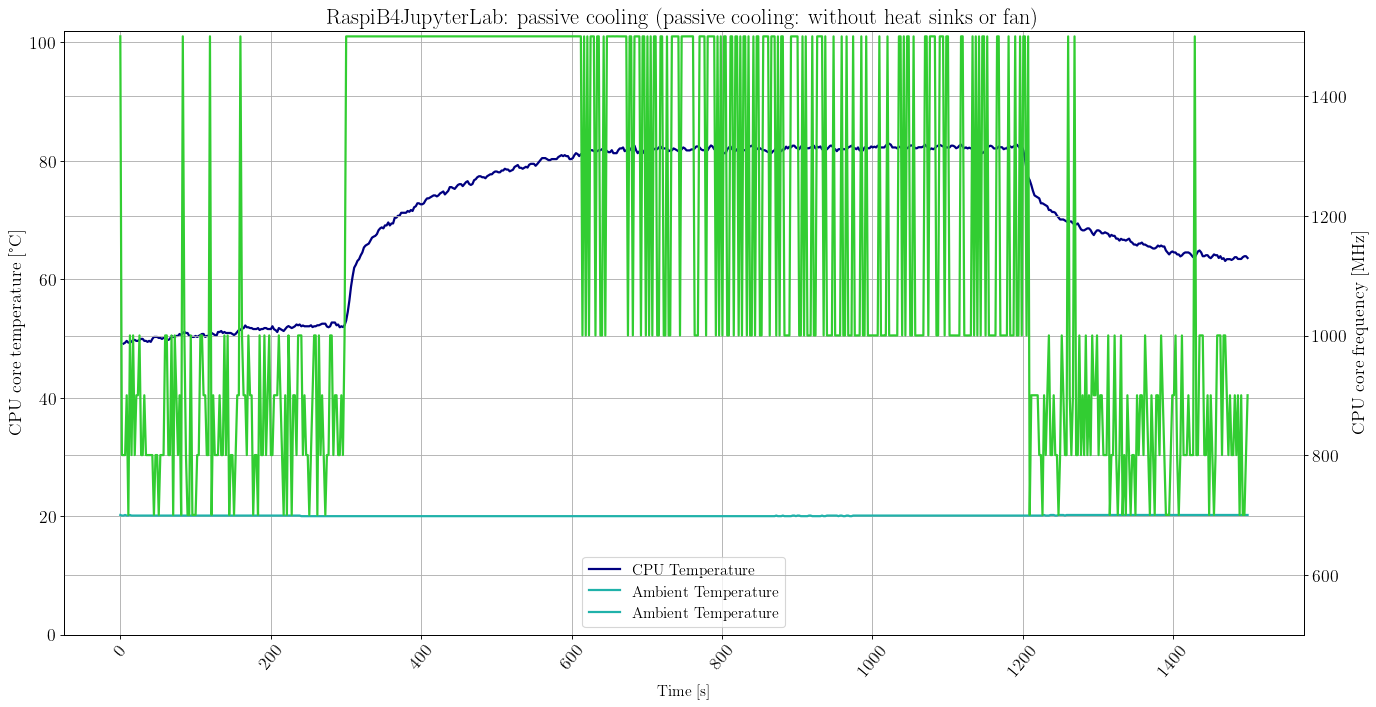

In [28]:
# Figsize: a tuple (width, height) in inches
# Create figure and axis objects with subplots()
fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

axes = plt.gca()

plt.title('RaspiB4JupyterLab: passive cooling (passive cooling: without heat sinks or fan)')

line1 = ax1.plot(df_1_PC_woHeatSinks['Time'], df_1_PC_woHeatSinks['CPU Temperature'], color='navy', label='CPU Temperature')
line2 = ax1.plot(df_1_PC_woHeatSinks['Time'], df_1_PC_woHeatSinks['Ambient Temperature'], color='lightseagreen', label='Ambient Temperature')

# Set x-axis label
ax1.set_xlabel('Time [s]', fontsize=14)
# Set y-axis label
ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
ax1.set_ylim(0, 102)
ax1.grid(True)
plt.xticks(rotation=50)

# Twin object for two different y-axis on the same plot
ax2 = ax1.twinx()

line3 = ax2.plot(df_1_PC_woHeatSinks['Time'], df_1_PC_woHeatSinks['CPU Frequency'], color='limegreen', label='CPU Frequency')

# Set y-axis label
ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
ax2.set_ylim(500, 1510)
ax2.grid(True)

# Add all lines to the same legend box
lines_all = line1+line2+line2
labels = [l.get_label() for l in lines_all]
ax1.legend(lines_all, labels, loc='lower center')

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_stress_measurement_PC_woHeatSinks'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### RaspiB4JupyterLab: Temperature curve compared with the curve of the CPU frequency (passive cooling: with heat sinks, but without fan)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks without fan".

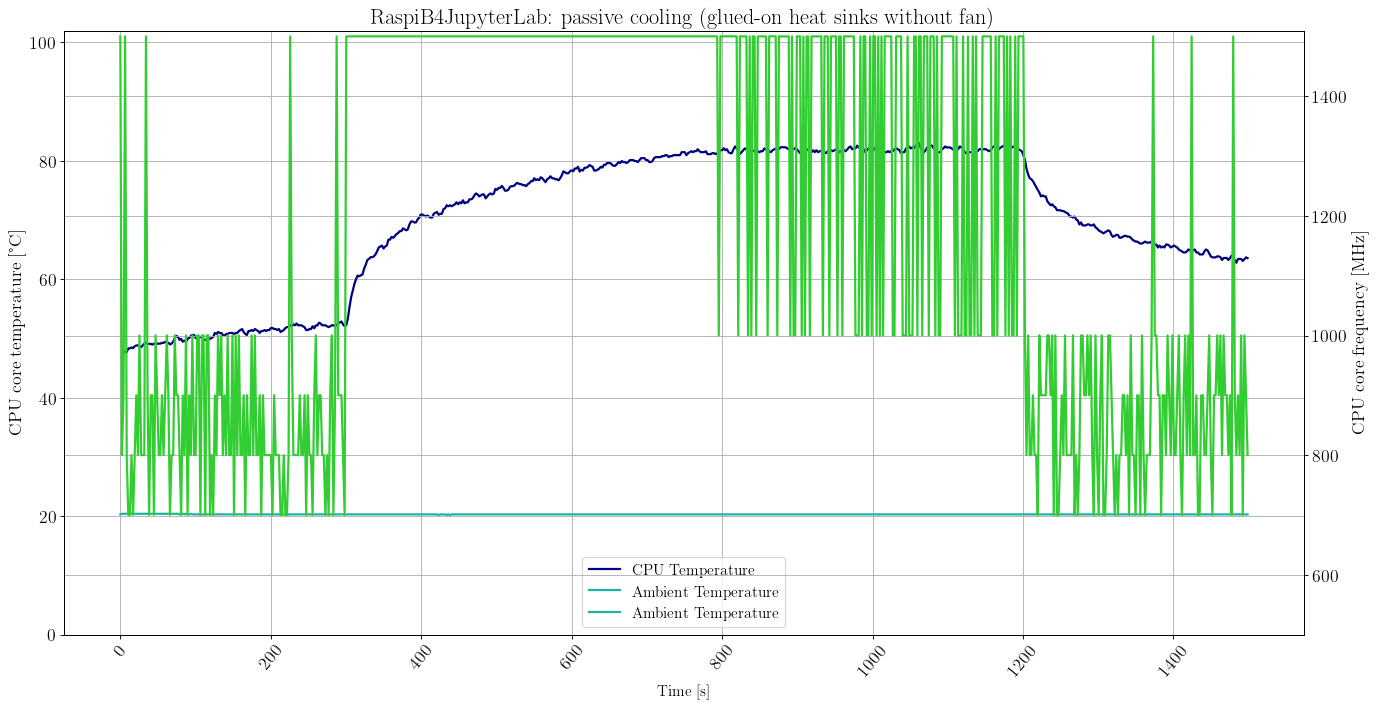

In [25]:
# Figsize: a tuple (width, height) in inches
# Create figure and axis objects with subplots()
fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

axes = plt.gca()

plt.title('RaspiB4JupyterLab: passive cooling (glued-on heat sinks without fan)')

line1 = ax1.plot(df_2_PC_wHeatSinks['Time'], df_2_PC_wHeatSinks['CPU Temperature'], color='navy', label='CPU Temperature')
line2 = ax1.plot(df_2_PC_wHeatSinks['Time'], df_2_PC_wHeatSinks['Ambient Temperature'], color='lightseagreen', label='Ambient Temperature')

# Set x-axis label
ax1.set_xlabel('Time [s]', fontsize=14)
# Set y-axis label
ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
ax1.set_ylim(0, 102)
ax1.grid(True)
plt.xticks(rotation=50)

# Twin object for two different y-axis on the same plot
ax2 = ax1.twinx()

line3 = ax2.plot(df_2_PC_wHeatSinks['Time'], df_2_PC_wHeatSinks['CPU Frequency'], color='limegreen', label='CPU Frequency')

# Set y-axis label
ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
ax2.set_ylim(500, 1510)
ax2.grid(True)

# Add all lines to the same legend box
lines_all = line1+line2+line2
labels = [l.get_label() for l in lines_all]
ax1.legend(lines_all, labels, loc='lower center')

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_stress_measurement_PC_wHeatSinks'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### RaspiB4JupyterLab: Temperature curve compared with the curve of the CPU frequency (active cooling)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "glued-on heat sinks with Noctua fan (driven by 3.3 V)".

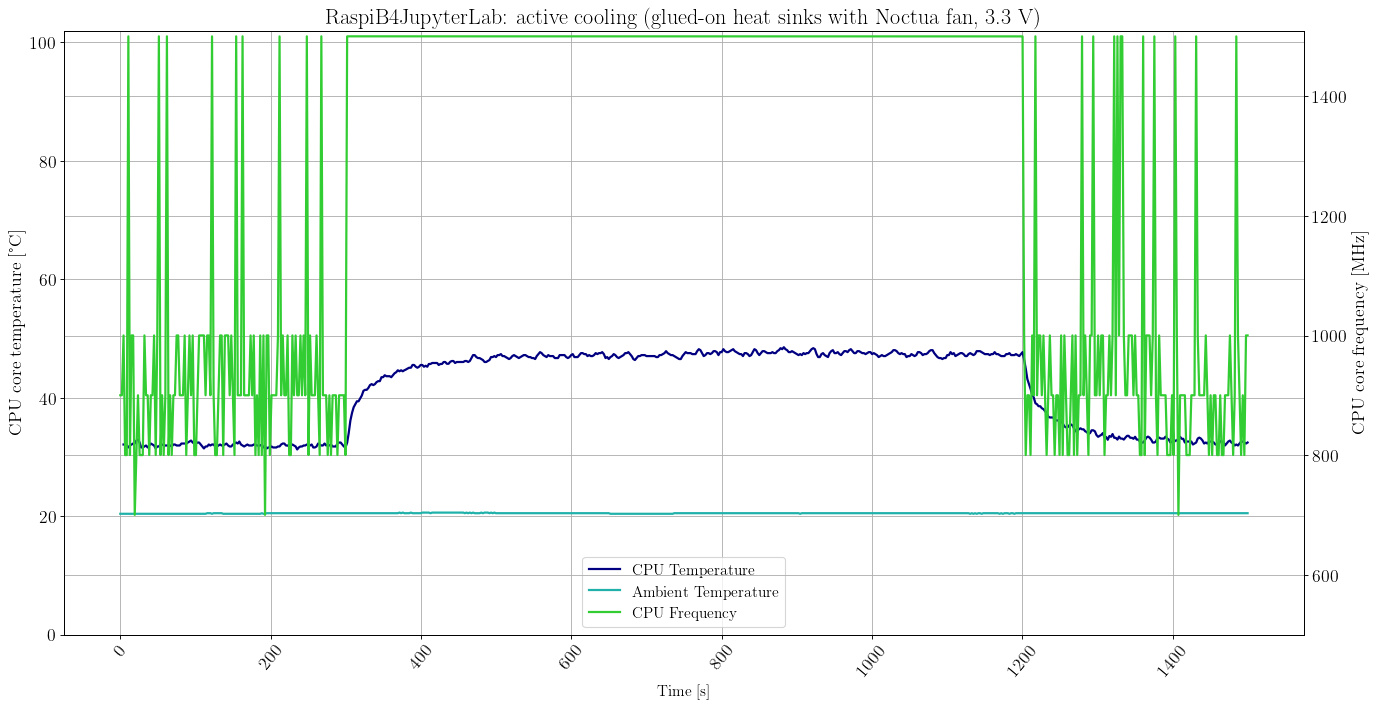

In [63]:
# Figsize: a tuple (width, height) in inches
# Create figure and axis objects with subplots()
fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

axes = plt.gca()

plt.title('RaspiB4JupyterLab: active cooling (glued-on heat sinks with Noctua fan, 3.3 V)')

line1 = ax1.plot(df_8_PC_wHeatSinksAndNoctuaFan3V['Time'], df_8_PC_wHeatSinksAndNoctuaFan3V['CPU Temperature'], color='navy', label='CPU Temperature')
line2 = ax1.plot(df_8_PC_wHeatSinksAndNoctuaFan3V['Time'], df_8_PC_wHeatSinksAndNoctuaFan3V['Ambient Temperature'], color='lightseagreen', label='Ambient Temperature')

# Set x-axis label
ax1.set_xlabel('Time [s]', fontsize=14)
# Set y-axis label
ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
ax1.set_ylim(0, 102)
ax1.grid(True)
plt.xticks(rotation=50)

# Twin object for two different y-axis on the same plot
ax2 = ax1.twinx()

line3 = ax2.plot(df_8_PC_wHeatSinksAndNoctuaFan3V['Time'], df_8_PC_wHeatSinksAndNoctuaFan3V['CPU Frequency'], color='limegreen', label='CPU Frequency')

# Set y-axis label
ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
ax2.set_ylim(500, 1510)
ax2.grid(True)

# Add all lines to the same legend box
lines_all = line1+line2+line3
labels = [l.get_label() for l in lines_all]
ax1.legend(lines_all, labels, loc='lower center')

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_stress_measurement_PC_wHeatSinksAndNoctuaFan3V'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()

### RaspiB4JupyterLab: Temperature curve compared with the curve of the CPU frequency (active cooling by controlled fan)

This is the plot of the temperature curve compared with the CPU frequency curve for the Raspberry Pi B4 with the cooling variant "wo Case and one big heat sink with controlled fan (driven by 5 V)".

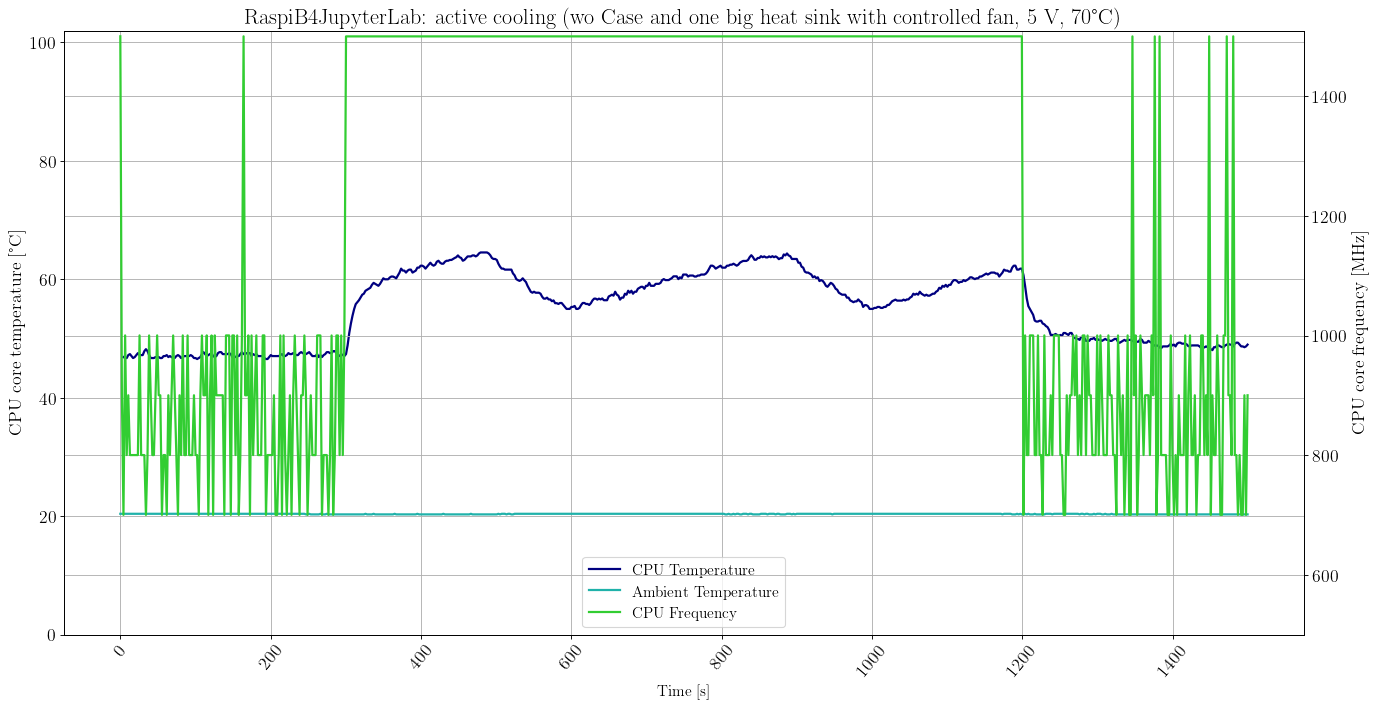

In [43]:
# Figsize: a tuple (width, height) in inches
# Create figure and axis objects with subplots()
fig, ax1 = plt.subplots(num=0, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

axes = plt.gca()

plt.title('RaspiB4JupyterLab: active cooling (wo Case and one big heat sink with controlled fan, 5 V, 70°C)')

# List of named colors: https://matplotlib.org/stable/gallery/color/named_colors.html
line1 = ax1.plot(df_10_woC_wHeatSinksAndCtrlFan5V['Time'], df_10_woC_wHeatSinksAndCtrlFan5V['CPU Temperature'], color='navy', label='CPU Temperature')
line2 = ax1.plot(df_10_woC_wHeatSinksAndCtrlFan5V['Time'], df_10_woC_wHeatSinksAndCtrlFan5V['Ambient Temperature'], color='lightseagreen', label='Ambient Temperature')

# Set x-axis label
ax1.set_xlabel('Time [s]', fontsize=14)
# Set y-axis label
ax1.set_ylabel('CPU core temperature [°C]', fontsize=16)
ax1.set_ylim(0, 102)
ax1.grid(True)
plt.xticks(rotation=50)

# Twin object for two different y-axis on the same plot
ax2 = ax1.twinx()

line3 = ax2.plot(df_10_woC_wHeatSinksAndCtrlFan5V['Time'], df_10_woC_wHeatSinksAndCtrlFan5V['CPU Frequency'], color='limegreen', label='CPU Frequency')

# Set y-axis label
ax2.set_ylabel('CPU core frequency [MHz]', fontsize=16)
ax2.set_ylim(500, 1510)
ax2.grid(True)

# Add all lines to the same legend box
lines_all = line1+line2+line3
labels = [l.get_label() for l in lines_all]
ax1.legend(lines_all, labels, loc='lower center')

# Save plot to PNG and PDF
str_image_name = 'RaspiB4JupyterLab_stress_measurement_woCase_wHeatSinksAndCtrlFan5V_70C'
#plt.savefig(r'./data_files/' + str_image_name + '.png')
plt.savefig(r'./data_files/' + str_image_name + '.pdf')

plt.show()